### Look at relationship between choice and preference decoders for some feature
- First pass: Just look at cosine similarity

In [23]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.pseudo_decoding.belief_partitions.belief_partition_configs import *
import scripts.pseudo_decoding.belief_partitions.belief_partitions_io as belief_partitions_io

import scipy
import argparse
import copy
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
def compute_for_feats(args):
    res = []
    for feat in FEATURES:
        args.feat = feat
        try: 
            pref_args = copy.deepcopy(args)
            pref_args.sig_unit_level = "pref_99th_window_filter_drift"
            pref_args.beh_filters = {"Response": "Correct", "Choice": "Chose"}

            pref_args.mode = "pref"
            pref_weights = belief_partitions_io.get_weights(pref_args)

            choice_args = copy.deepcopy(args)
            choice_args.base_output_path = "/data/patrick_res/choice_reward"
            choice_args.sig_unit_level = "choice_99th_window_filter_drift"
            choice_args.mode = "choice"
            # choice_args.mode = "choice"

            choice_weights = belief_partitions_io.get_weights(choice_args)  
        except Exception as e: 
            if args.shuffle_idx is None:
                raise e
            else: 
                print(f"Can't find {args.feat}, {args.shuffle_idx}")
                continue

        merged = pd.merge(choice_weights, pref_weights, on="PseudoUnitID", suffixes=("_choice", "_pref"), how="outer").fillna(0)
        sims = merged.groupby(["Time_choice", "Time_pref"]).apply(lambda x: classifier_utils.cosine_sim(x.weightsdiff_choice, x.weightsdiff_pref)).reset_index(name="cosine_sim")
        # sims = merged.groupby(["Time_choice", "Time_pref"]).apply(lambda x: classifier_utils.cosine_sim(x.weightsdiff_normed_choice, x.weightsdiff_normed_pref)).reset_index(name="cosine_sim")
        sims["feat"] = feat
        res.append(sims)
    res = pd.concat(res)
    return res


In [25]:
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.trial_event = "FeedbackOnsetLong"
args.subject = "both"
# args.region_level = "structure_level2_cleaned"
# # args.regions = "lateral_prefrontal_cortex_lat_PFC"
# args.regions = "inferior_temporal_cortex_ITC"

res = compute_for_feats(args)
avg_res = res.groupby(["Time_choice", "Time_pref"]).mean("cosine_sim").reset_index()

In [26]:
all_shuffle_res = []
for shuffle_idx in tqdm(range(10)):
    shuffle_args = copy.deepcopy(args)
    shuffle_args.shuffle_idx = shuffle_idx
    shuffle_res = compute_for_feats(shuffle_args)
    shuffle_res["shuffle_idx"] = shuffle_idx
    all_shuffle_res.append(shuffle_res)
all_shuffle_res= pd.concat(all_shuffle_res)

 40%|████      | 4/10 [00:18<00:27,  4.52s/it]

Can't find MAGENTA, 4


 50%|█████     | 5/10 [00:22<00:21,  4.38s/it]

Can't find CIRCLE, 5


 80%|████████  | 8/10 [00:35<00:08,  4.39s/it]

Can't find STAR, 8
Can't find ESCHER, 8


100%|██████████| 10/10 [00:43<00:00,  4.36s/it]


In [27]:
all_shuffle_res

,Time_choice,Time_pref,cosine_sim,feat,shuffle_idx
0,-1.7,-1.7,-0.122740,CIRCLE,0
1,-1.7,-1.6,-0.128726,CIRCLE,0
2,-1.7,-1.5,-0.038410,CIRCLE,0
3,-1.7,-1.4,0.036989,CIRCLE,0
4,-1.7,-1.3,0.059850,CIRCLE,0
...,...,...,...,...,...
1084,1.5,1.1,0.218171,SWIRL,9
1085,1.5,1.2,0.141626,SWIRL,9
1086,1.5,1.3,0.067456,SWIRL,9
1087,1.5,1.4,0.035300,SWIRL,9


<Axes: xlabel='Time_choice', ylabel='Time_pref'>

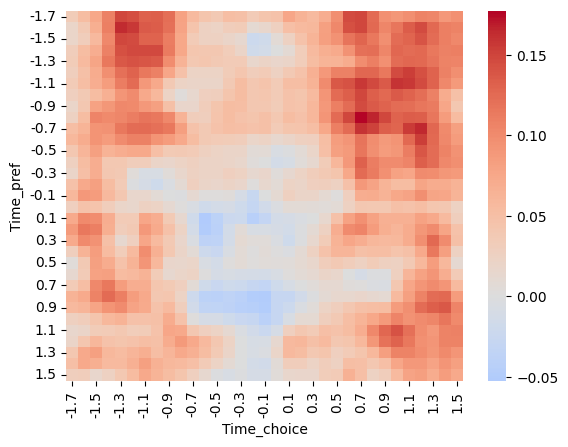

In [28]:
pivoted = avg_res.pivot(index="Time_pref", columns="Time_choice", values="cosine_sim")
sns.heatmap(pivoted, cmap='coolwarm', center=0)

In [29]:
match_res = res[res.Time_choice == res.Time_pref]
shuffle_match_res = all_shuffle_res[all_shuffle_res.Time_choice == all_shuffle_res.Time_pref]


In [30]:
match_res

,Time_choice,Time_pref,cosine_sim,feat
0,-1.7,-1.7,0.225469,CIRCLE
34,-1.6,-1.6,0.249697,CIRCLE
68,-1.5,-1.5,0.203839,CIRCLE
102,-1.4,-1.4,0.220414,CIRCLE
136,-1.3,-1.3,0.227091,CIRCLE
...,...,...,...,...
952,1.1,1.1,0.368627,SWIRL
986,1.2,1.2,0.406960,SWIRL
1020,1.3,1.3,0.171060,SWIRL
1054,1.4,1.4,0.003811,SWIRL


<Axes: xlabel='Time_choice', ylabel='cosine_sim'>

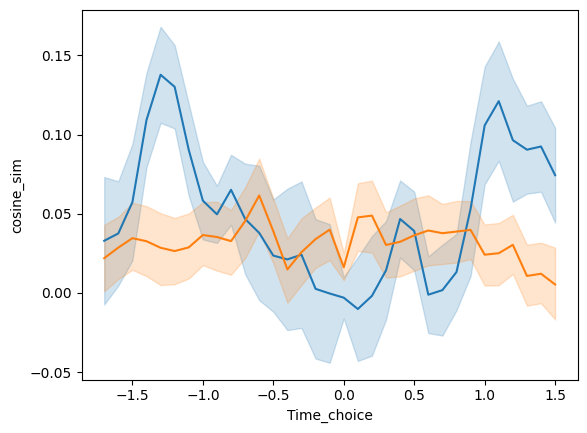

In [31]:
fig, ax = plt.subplots()
sns.lineplot(match_res, x="Time_choice", y="cosine_sim", errorbar="se", ax=ax)
sns.lineplot(shuffle_match_res, x="Time_choice", y="cosine_sim", errorbar="ci", ax=ax)


res